# Gestión de carteras

# Importamos librerias

In [98]:
import math
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
import yfinance as yf
import pandas as pd
from pylab import mpl, plt

## Definimos las características de los gráficos 

In [99]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

## Recuperamos precios y calculamos rentabilidades 

In [100]:
symbols = ["MSFT","AAPL","GLD","SPY"]
tickers = yf.Tickers(symbols) 

In [101]:
data = tickers.history(start='2012-01-01',end='2018-06-29').Close.dropna()

[*********************100%***********************]  4 of 4 completed


<AxesSubplot:xlabel='Date'>

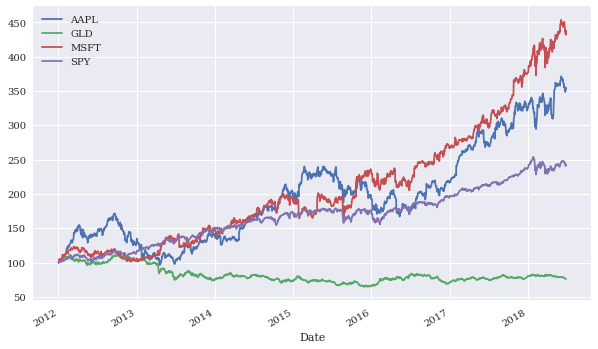

In [102]:
(data / data.iloc[0] * 100).plot(figsize=(10, 6))

array([[<AxesSubplot:title={'center':'AAPL'}>,
        <AxesSubplot:title={'center':'GLD'}>],
       [<AxesSubplot:title={'center':'MSFT'}>,
        <AxesSubplot:title={'center':'SPY'}>]], dtype=object)

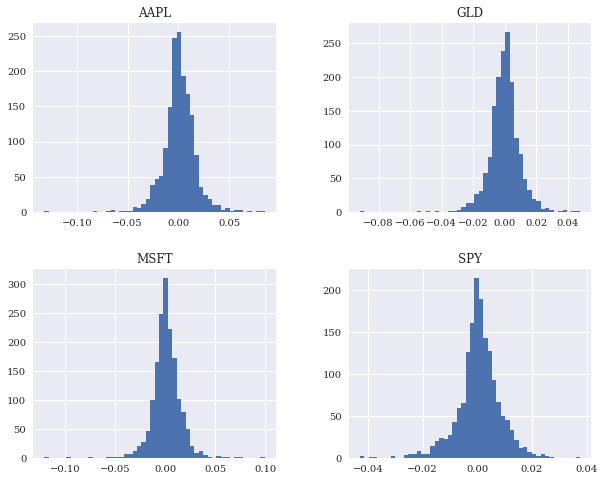

In [103]:
rets = np.log(data / data.shift(1))
rets.hist(bins=50, figsize=(10, 8))

## Creamos una cartera aleatoria con cuatro títulos 

Nos guardamos la cantidad de activos en una variable

In [104]:
noa = len(symbols)

Calculamos la media anualizada, en días laborables

In [105]:
rets.mean() * 252

AAPL    0.195649
GLD    -0.042741
MSFT    0.227577
SPY     0.136543
dtype: float64

Covarianza entre activos anualizada

In [106]:
rets.cov() * 252

,AAPL,GLD,MSFT,SPY
AAPL,0.061797,0.000519,0.020188,0.015887
GLD,0.000519,0.023477,-0.000764,-0.000559
MSFT,0.020188,-0.000764,0.050414,0.017882
SPY,0.015887,-0.000559,0.017882,0.015392


Vamos a generar unos pesos random para la cartera

In [107]:
weights = np.random.random(noa)
print(weights)

[0.84242485 0.79376834 0.39996954 0.44369456]


Normalizamos los pesos, es decir que sumen 1

In [108]:
weights /= np.sum(weights)
print(weights)

[0.33970699 0.3200863  0.16128732 0.17891939]


Calculamos la rentabilidad de la cartera

In [109]:
np.dot(rets.mean().T *252, weights)   

0.11391815468767452

Calculamos la volatilidad de la cartera

In [110]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.016486541840773306

In [111]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.12839992928648095

Transformamos la rentabilidad y la volatilidad en una función

In [112]:
def port_ret(weights, rets):
    return np.dot(rets.mean().T *252, weights)

In [113]:
def port_vol(weights,rets):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

Creamos una función para los pesos

In [114]:
def pesos_aleatorios(noa):
    pesos = np.random.random(noa)
    pesos /= np.sum(pesos)
    return pesos

Generamos 2500 carteras aleatorias

In [115]:
prets = [] 
pvols = [] 

In [116]:
for p in range (2500):
    weights = pesos_aleatorios(noa)
    prets.append(port_ret(weights,rets=rets))
    pvols.append(port_vol(weights,rets=rets))

In [117]:
prets = np.array(prets) 
pvols = np.array(pvols)

C:\Users\adriy\AppData\Local\Temp\ipykernel_3200\3727922512.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Sharpe ratio')


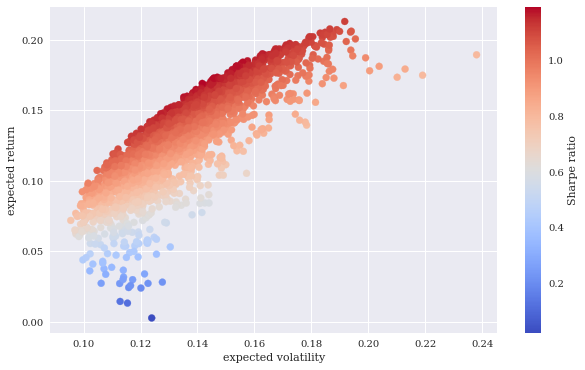

In [118]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

# Cartera eficiente para c=0

Vamos a ver que existe un metodo mediante optimización cuadrática

In [119]:
import scipy.optimize as sco

In [120]:
def min_func_sharpe(weights,rets):
    return -port_ret(weights,rets) / port_vol(weights,rets)

In [121]:
bnds = tuple((0, 1) for x in range(noa))
cons = ({'type': 'eq', 'fun': lambda x:np.sum(x) - 1})
eweights = np.array(noa * [1. / noa,])
eweights

array([0.25, 0.25, 0.25, 0.25])

In [122]:
min_func_sharpe(eweights,rets=rets)

-1.0191111905290013

In [123]:
opts = sco.minimize(lambda x : min_func_sharpe(x,rets=rets), eweights, method='SLSQP', bounds=bnds, constraints=cons)
opts

     fun: -1.195150148361535
     jac: array([ 2.50875950e-04,  2.74591640e-01, -7.15553761e-05, -2.34395266e-05])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.13221911, 0.        , 0.26691545, 0.60086544])

In [124]:
opts['x'].round(3)

array([0.132, 0.   , 0.267, 0.601])

In [125]:
rentabilidad = port_ret(opts['x'],rets=rets).round(3)
rentabilidad

0.169

In [126]:
volatilidad = port_vol(opts['x'],rets=rets).round(3)
volatilidad

0.141

In [127]:
sharpe = rentabilidad / volatilidad
sharpe

1.1985815602836882

# Cartera de Mínima Varianza

In [128]:
optv = sco.minimize(lambda x : port_vol(x,rets=rets), eweights, method='SLSQP', bounds=bnds, constraints=cons)
optv

     fun: 0.0950211987213909
     jac: array([0.10271955, 0.0949652 , 0.10995445, 0.09505833])
 message: 'Optimization terminated successfully'
    nfev: 40
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.        , 0.39867521, 0.        , 0.60132479])

In [129]:
optv['x'].round(3)

array([0.   , 0.399, 0.   , 0.601])

In [130]:
rentabilidad = port_ret(opts['x'],rets=rets).round(3)
rentabilidad 

0.169

In [131]:
volatilidad = port_vol(opts['x'],rets=rets).round(3)
volatilidad

0.141

In [132]:
sharpe = rentabilidad / volatilidad
sharpe

1.1985815602836882

# Frontera eficiente

In [133]:
cons = ({'type': 'eq', 'fun': lambda x:  port_ret(x,rets=rets) - tret},
                 {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [146]:

trets = np.linspace(0.05, 0.2, 50)
tvols = []
for tret in trets:
    res = sco.minimize(lambda x : port_vol(x,rets=rets), eweights, method='SLSQP',bounds=bnds, constraints=cons)  
    tvols.append(res['fun'])
tvols = np.array(tvols)

In [147]:
print(tvols)

[0.09648813 0.09595394 0.09553887 0.09524447 0.09507185 0.0950217
 0.09509419 0.09528905 0.09560554 0.09603678 0.0965753  0.09720681
 0.09792261 0.09872032 0.09959884 0.10055569 0.10158867 0.10269548
 0.10387376 0.10512139 0.10643507 0.10781324 0.10925318 0.11075248
 0.11230882 0.11391972 0.11558307 0.11729644 0.11905785 0.12086512
 0.12271626 0.12460953 0.12654232 0.12851361 0.13052134 0.13256387
 0.13464202 0.13684497 0.13921155 0.14173356 0.14440287 0.1472114
 0.15015141 0.15321532 0.15639583 0.15968598 0.16307954 0.16656929
 0.17014984 0.17381555]


C:\Users\adriy\AppData\Local\Temp\ipykernel_3200\3846383221.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Sharpe ratio')


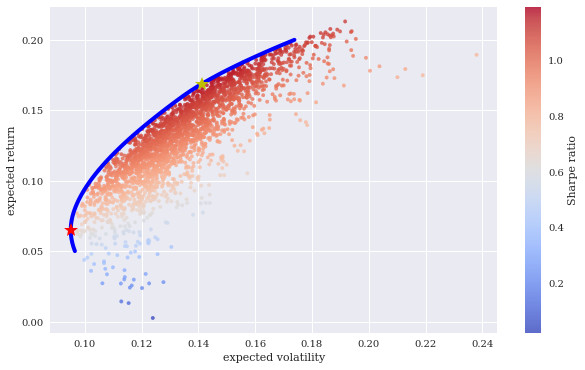

In [148]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x'],rets=rets), port_ret(opts['x'],rets=rets),'y*', markersize=15.0)
plt.plot(port_vol(optv['x'],rets=rets), port_ret(optv['x'],rets=rets),'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

# Linea del mercado de capitales

In [137]:
import scipy.interpolate as sci

In [138]:
ind = np.argmin(tvols)
print(ind)

0


In [139]:
evols = tvols[ind:]
erets = trets[ind:]

In [140]:
tck = sci.splrep(evols, erets)
tck

(array([0.11054923, 0.11054923, 0.11054923, 0.11054923, 0.11220332,
        0.11305387, 0.11391972, 0.11480052, 0.11569577, 0.11660528,
        0.11752856, 0.11846585, 0.11941569, 0.12037881, 0.12135455,
        0.12234262, 0.1233427 , 0.12435459, 0.12537777, 0.12641224,
        0.12745761, 0.12851361, 0.12957997, 0.13065644, 0.13174278,
        0.13283876, 0.13394403, 0.13506913, 0.13624118, 0.1374604 ,
        0.13872555, 0.14003536, 0.1413886 , 0.14278405, 0.14422054,
        0.14569666, 0.1472114 , 0.14876354, 0.1503519 , 0.15197536,
        0.15363402, 0.15532314, 0.15704531, 0.15879827, 0.16058102,
        0.16239258, 0.16423234, 0.16609862, 0.16799094, 0.16990842,
        0.17381555, 0.17381555, 0.17381555, 0.17381555]),
 array([0.12      , 0.12111006, 0.12275634, 0.12491251, 0.12654461,
        0.1281765 , 0.12980888, 0.1314407 , 0.13307374, 0.13470446,
        0.13633806, 0.13796973, 0.1396021 , 0.14123434, 0.14286676,
        0.14449879, 0.14613145, 0.14776364, 0.14939601, 0.

In [141]:
def f(x):
    return sci.splev(x, tck, der=0)
def df(x):
    return sci.splev(x, tck, der=1)

In [142]:
def equations(p, rf=0.01):
    eq1 = rf - p[0]  
    eq2 = rf + p[1] * p[2] - f(p[2])  
    eq3 = p[1] - df(p[2])  
    return eq1, eq2, eq3

In [143]:
opt = sco.fsolve(equations, [0.01, 0.5, 0.15]) 

In [144]:
opt

array([0.01      , 1.12498045, 0.14402783])

C:\Users\adriy\AppData\Local\Temp\ipykernel_3200\246825966.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Sharpe ratio')


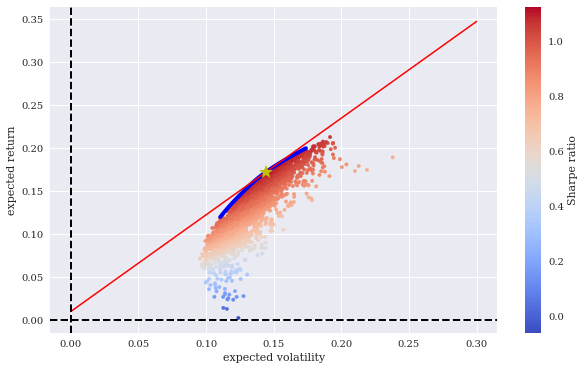

In [145]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=(prets - 0.01) / pvols,marker='.', cmap='coolwarm')
plt.plot(evols, erets, 'b', lw=4.0)
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5)
plt.plot(opt[2], f(opt[2]), 'y*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

___
# Ejercicios

- Pinta la frontera eficiente de una cartera con los activos **Amazon**, **Berkshire Hathaway Inc Class A**, **The British Petroleum Company**